# Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.metrics import zero_one_loss

%matplotlib inline

In [3]:
from utils.data_gen import compute_bayes_risk_binary, compute_bayes_risk_binary_label_shift,\
    generate_2d_example

from utils.concentrations import hoeffding_ci_lower_limit,\
    hoeffding_ci_upper_limit
from utils.concentrations import pm_bernstein_ci_upper_limit,\
    pm_bernstein_ci_lower_limit

from utils.concentrations import pm_bernstein_lower_limit, pm_bernstein_upper_limit
from utils.concentrations import pm_hoeffding_upper_limit, pm_hoeffding_lower_limit

from utils.data_gen import LDA_predictor

from utils.concentrations import betting_ci_lower_limit, betting_ci_upper_limit

from utils.tests import Drop_tester,misclas_losses

In [4]:
sns.set(
    style="whitegrid",
    font_scale=1.4,
    rc={
        "lines.linewidth": 2,
        #             "axes.facecolor": ".9",
        'figure.figsize': (12, 6)
    })
sns.set_palette('Set2')
matplotlib.rcParams['text.usetex'] = True

In [5]:
legend_dict = ['$\{0\}$', '$\{1\}$']
clr1 = np.array([193, 142, 206]) / 256
clr2 = np.array([125, 225, 125]) / 256
colors = [clr1, clr2]

color1 = np.array([244, 236, 118]) / 256
color2 = np.array([110, 200, 235]) / 256
color3 = np.array([233, 113, 183]) / 256

In [6]:
%load_ext autoreload
%autoreload 2

# Null vs alternative

In [7]:
mu_1 = np.array([1,0])
mu_0 = np.array([-1,0])
target_prob_class_1 = np.linspace(0.1,0.9,100)

eps_tol = 0.05

In [8]:
risk_source = compute_bayes_risk_binary_label_shift(0.25, 0.25, mu_1,
                                                    mu_0)[0][0]

In [9]:
risk_source

0.1270168302054692

In [10]:
target_risks = list()

In [11]:
for cur_target_prob in target_prob_class_1:
    target_risks += [
        compute_bayes_risk_binary_label_shift(0.25, cur_target_prob, mu_1,
                                              mu_0)[0][0]
    ]
target_risks = np.array(target_risks)

In [12]:
nulls = (target_risks-risk_source<=eps_tol)

In [13]:
target_prob_class_1[np.argmin(nulls == True)]

0.43939393939393945

Text(0.5, 0, 'Class 1 probability')

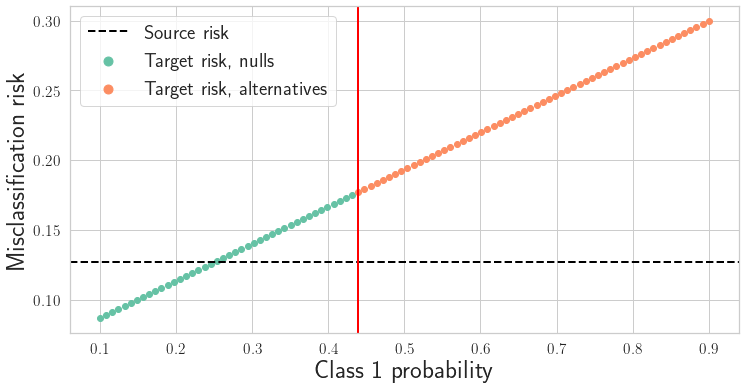

In [14]:
plt.scatter(target_prob_class_1[nulls],
            target_risks[nulls],
            label='Target risk, nulls')
plt.scatter(target_prob_class_1[~nulls],
            target_risks[~nulls],
            label='Target risk, alternatives')
plt.axhline(y=risk_source, linestyle='dashed', c='black', label='Source risk')
plt.axvline(x=target_prob_class_1[np.argmin(nulls == True)], c='red')
plt.legend(loc=2, markerscale=1.5, prop={'size': 20})
plt.ylabel('Misclassification risk', fontsize=25)
plt.xlabel('Class 1 probability', fontsize=25)
# plt.show()
# plt.savefig('img/nulls_vs_alternatives.pdf', bbox_inches='tight')

# Comparison of betting and conjugate emp bernstein

In [15]:
num_of_repeats = 250
num_of_batches_to_sample = 80

size_of_batch = 25
size_source_sample = 1000

In [16]:
mu_1 = np.array([1, 0])
mu_0 = np.array([-1, 0])
prob_class_1 = 0.25
prob_class_0 = 1 - prob_class_1
cov = np.eye(2)

In [17]:
clf = LDA_predictor()

clf.mean_class_0 = mu_0
clf.mean_class_1 = mu_1
clf.class_0_prior = prob_class_0
clf.class_1_prior = prob_class_1

In [18]:
eps_tol = 0

In [19]:
tester_conj_bernstein = Drop_tester()
tester_bernstein = Drop_tester()
tester_betting = Drop_tester()

tester_conj_bernstein.eps_tol = eps_tol
tester_conj_bernstein.target_conc_type = 'conj-bern'


tester_bernstein.eps_tol = eps_tol
tester_bernstein.target_conc_type = 'pm_bernstein'


tester_betting.eps_tol = eps_tol

In [81]:
conj_bern_target_lower_bounds = list()
conj_bern_target_sample_sizes = list()

pm_bern_target_lower_bounds = list()
pm_bern_target_sample_sizes = list()

bet_target_lower_bounds = list()
bet_target_sample_sizes = list()

conj_bern_rej_thrs = list()
pm_bern_rej_thrs = list()
bet_rej_thrs = list()

In [20]:
target_prob_class_1 = 0.75

In [83]:
for cur_sim in range(num_of_repeats):
    conj_bern_target_lower_bounds += [[]]
    conj_bern_target_sample_sizes += [[]]

    pm_bern_target_lower_bounds += [[]]
    pm_bern_target_sample_sizes += [[]]

    bet_target_lower_bounds += [[]]
    bet_target_sample_sizes += [[]]

    X_val_source, y_val_source = generate_2d_example(0.25, mu_0, mu_1,
                                                     size_source_sample)

    y_pred_val = clf.predict(X_val_source)
    ind_loss_source = misclas_losses(y_pred_val, y_val_source)
    
    tester_conj_bernstein.estimate_risk_source(ind_loss_source)
    tester_bernstein.estimate_risk_source(ind_loss_source)
    tester_betting.estimate_risk_source(ind_loss_source)

    conj_bern_rej_thrs += [tester_conj_bernstein.source_rejection_threshold]
    pm_bern_rej_thrs += [tester_bernstein.source_rejection_threshold]
    bet_rej_thrs += [tester_betting.source_rejection_threshold]

    X_new_target, y_new_target = generate_2d_example(
        target_prob_class_1, mu_0, mu_1,
        size_of_batch * num_of_batches_to_sample)
    
    y_pred_target = clf.predict(X_new_target)
    ind_loss_target = misclas_losses(y_pred_target, y_new_target)


    
    for cur_batch in range(num_of_batches_to_sample):
        cur_losses = ind_loss_target[0:(cur_batch + 1) * size_of_batch]
        tester_conj_bernstein.estimate_risk_target(cur_losses)
        conj_bern_target_lower_bounds[cur_sim] += [tester_conj_bernstein.target_risk_lower_bound]
        conj_bern_target_sample_sizes[cur_sim] += [tester_conj_bernstein.target_num_of_samples_used]
    
    for cur_batch in range(num_of_batches_to_sample):
        cur_losses = ind_loss_target[0:(cur_batch + 1) * size_of_batch]
        tester_bernstein.estimate_risk_target(cur_losses)
        pm_bern_target_lower_bounds[cur_sim] += [tester_bernstein.target_risk_lower_bound]
        pm_bern_target_sample_sizes[cur_sim] += [tester_bernstein.target_num_of_samples_used]

    for cur_batch in range(num_of_batches_to_sample):
        cur_losses = ind_loss_target[0:(cur_batch + 1) * size_of_batch]
        tester_betting.estimate_risk_target(cur_losses)
        bet_target_lower_bounds[cur_sim] += [tester_betting.target_risk_lower_bound]
        bet_target_sample_sizes[cur_sim] += [tester_betting.target_num_of_samples_used]
    

In [25]:
from utils.tests import brier_scores

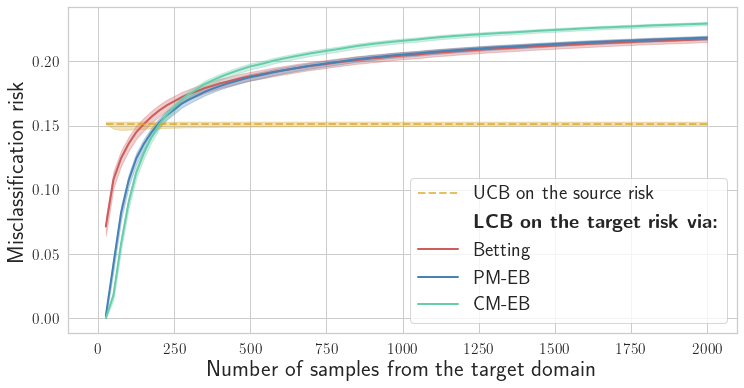

In [87]:
l1, = plt.plot(bet_target_sample_sizes[0],
               np.mean(bet_target_lower_bounds, axis=0),
               label='Lower bound on the target risk, Betting',
               color='indianred')

plt.fill_between(
    bet_target_sample_sizes[0],
    y1=np.mean(bet_target_lower_bounds, axis=0) -
    2 * np.std(bet_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    y2=np.mean(bet_target_lower_bounds, axis=0) +
    2 * np.std(bet_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    alpha=0.3,
    color='indianred')

l2, = plt.plot(pm_bern_target_sample_sizes[0],
               np.mean(pm_bern_target_lower_bounds, axis=0),
               label='Lower bound on the target risk, PM-EB',
               color='steelblue')

plt.fill_between(
    pm_bern_target_sample_sizes[0],
    y1=np.mean(pm_bern_target_lower_bounds, axis=0) -
    2 * np.std(pm_bern_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    y2=np.mean(pm_bern_target_lower_bounds, axis=0) +
    2 * np.std(pm_bern_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    alpha=0.3,
    color='steelblue')

l3, = plt.plot(conj_bern_target_sample_sizes[0],
               np.mean(conj_bern_target_lower_bounds, axis=0),
               label='Lower bound on the target risk,  conj mixtures',
               color='mediumaquamarine')

plt.fill_between(
    conj_bern_target_sample_sizes[0],
    y1=np.mean(conj_bern_target_lower_bounds, axis=0) - 2 *
    np.std(conj_bern_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    y2=np.mean(conj_bern_target_lower_bounds, axis=0) + 2 *
    np.std(conj_bern_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    alpha=0.3,
    color='mediumaquamarine')

p5, = plt.plot([0.15], marker='None', linestyle='None', label='dummy-tophead')

l4, = plt.plot(conj_bern_target_sample_sizes[0],
               np.repeat(np.mean(conj_bern_rej_thrs, axis=0),
                         len(conj_bern_target_sample_sizes[0])),
               linestyle='dashed',
               color='goldenrod',
               alpha=0.7)

# l4 = plt.axhline(y=np.mean(conj_bern_rej_thrs),
#                  linestyle='dashed',
#                  c='goldenrod',
#                  alpha=0.7)

plt.fill_between(
    conj_bern_target_sample_sizes[0],
    y1=np.mean(conj_bern_rej_thrs, axis=0) - 2 *
    np.std(conj_bern_rej_thrs, axis=0) / np.sqrt(num_of_repeats),
    y2=np.mean(conj_bern_rej_thrs, axis=0) +
    2 * np.std(conj_bern_rej_thrs, axis=0) / np.sqrt(num_of_repeats),
    alpha=0.3,
    color='goldenrod')

categories = [
    'UCB on the source risk', r'$\textbf{LCB on the target risk via:}$ ',
    'Betting', 'PM-EB', 'CM-EB'
]

leg4 = plt.legend([l4, p5, l1, l2, l3],
                  categories,
                  loc=4,
                  ncol=1,
                  prop={'size': 20})  # Two columns, horizontal group labels

plt.ylabel('Misclassification risk', fontsize=23)
plt.xlabel('Number of samples from the target domain', fontsize=23)
plt.savefig('img/lower_bounds_misclas.pdf', bbox_inches='tight')

# Comparison of betting and conjugate emp bernstein /// Brier score

In [37]:
clf = LDA_predictor()

clf.mean_class_0 = mu_0
clf.mean_class_1 = mu_1
clf.class_0_prior = prob_class_0
clf.class_1_prior = prob_class_1

clf.predict_both_classes=True

In [42]:
tester_conj_bernstein = Drop_tester()
tester_bernstein = Drop_tester()
tester_betting = Drop_tester()

tester_conj_bernstein.eps_tol = eps_tol
tester_conj_bernstein.target_conc_type = 'conj-bern'
tester_conj_bernstein.change_type = 'relative'

tester_bernstein.eps_tol = eps_tol
tester_bernstein.source_conc_type = 'betting'
tester_bernstein.target_conc_type = 'pm_bernstein'
tester_bernstein.change_type = 'relative'
# tester_betting_bernstein.model = clf
# tester_betting_bernstein.eps_tol = eps_tol
# tester_betting_bernstein.source_conc_type = 'betting'
# tester_betting_bernstein.target_conc_type = 'pm_bernstein'

tester_betting.eps_tol = eps_tol
tester_betting.change_type = 'relative'
# tester_betting.source_conc_type = 'betting'
# tester_betting.target_conc_type = 'betting'

In [43]:
conj_bern_target_lower_bounds = list()
conj_bern_target_sample_sizes = list()

pm_bern_target_lower_bounds = list()
pm_bern_target_sample_sizes = list()

bet_target_lower_bounds = list()
bet_target_sample_sizes = list()

conj_bern_rej_thrs = list()
pm_bern_rej_thrs = list()
bet_rej_thrs = list()

In [44]:
for cur_sim in range(num_of_repeats):
    conj_bern_target_lower_bounds += [[]]
    conj_bern_target_sample_sizes += [[]]

    pm_bern_target_lower_bounds += [[]]
    pm_bern_target_sample_sizes += [[]]

    bet_target_lower_bounds += [[]]
    bet_target_sample_sizes += [[]]

    X_val_source, y_val_source = generate_2d_example(0.25, mu_0, mu_1,
                                                     size_source_sample)

    y_pred_val = clf.predict_proba(X_val_source)
    ind_loss_source = brier_scores(y_val_source,y_pred_val)
    
    tester_conj_bernstein.estimate_risk_source(ind_loss_source)
    tester_bernstein.estimate_risk_source(ind_loss_source)
    tester_betting.estimate_risk_source(ind_loss_source)

    conj_bern_rej_thrs += [tester_conj_bernstein.source_rejection_threshold]
    pm_bern_rej_thrs += [tester_bernstein.source_rejection_threshold]
    bet_rej_thrs += [tester_betting.source_rejection_threshold]

    X_new_target, y_new_target = generate_2d_example(
        target_prob_class_1, mu_0, mu_1,
        size_of_batch * num_of_batches_to_sample)
    
    y_pred_target = clf.predict_proba(X_new_target)
    ind_loss_target = brier_scores(y_new_target, y_pred_target)


    
    for cur_batch in range(num_of_batches_to_sample):
        cur_losses = ind_loss_target[0:(cur_batch + 1) * size_of_batch]
        tester_conj_bernstein.estimate_risk_target(cur_losses)
        conj_bern_target_lower_bounds[cur_sim] += [tester_conj_bernstein.target_risk_lower_bound]
        conj_bern_target_sample_sizes[cur_sim] += [tester_conj_bernstein.target_num_of_samples_used]
    
    for cur_batch in range(num_of_batches_to_sample):
        cur_losses = ind_loss_target[0:(cur_batch + 1) * size_of_batch]
        tester_bernstein.estimate_risk_target(cur_losses)
        pm_bern_target_lower_bounds[cur_sim] += [tester_bernstein.target_risk_lower_bound]
        pm_bern_target_sample_sizes[cur_sim] += [tester_bernstein.target_num_of_samples_used]

    for cur_batch in range(num_of_batches_to_sample):
        cur_losses = ind_loss_target[0:(cur_batch + 1) * size_of_batch]
        tester_betting.estimate_risk_target(cur_losses)
        bet_target_lower_bounds[cur_sim] += [tester_betting.target_risk_lower_bound]
        bet_target_sample_sizes[cur_sim] += [tester_betting.target_num_of_samples_used]
    

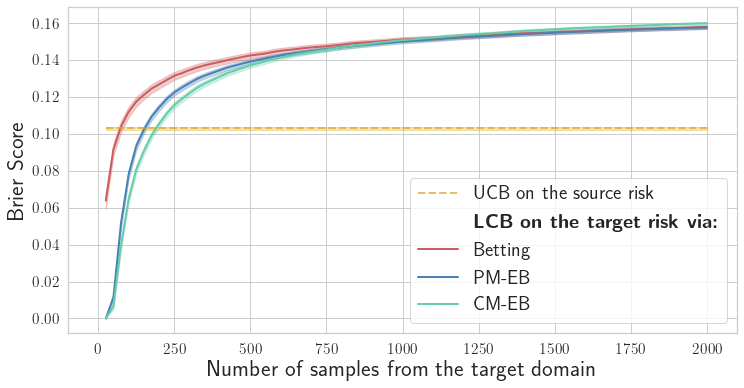

In [45]:
l1, = plt.plot(bet_target_sample_sizes[0],
               np.mean(bet_target_lower_bounds, axis=0),
               label='Lower bound on the target risk, Betting',
               color='indianred')

plt.fill_between(
    bet_target_sample_sizes[0],
    y1=np.mean(bet_target_lower_bounds, axis=0) -
    2 * np.std(bet_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    y2=np.mean(bet_target_lower_bounds, axis=0) +
    2 * np.std(bet_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    alpha=0.3,
    color='indianred')

l2, = plt.plot(pm_bern_target_sample_sizes[0],
               np.mean(pm_bern_target_lower_bounds, axis=0),
               label='Lower bound on the target risk, PM-EB',
               color='steelblue')

plt.fill_between(
    pm_bern_target_sample_sizes[0],
    y1=np.mean(pm_bern_target_lower_bounds, axis=0) -
    2 * np.std(pm_bern_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    y2=np.mean(pm_bern_target_lower_bounds, axis=0) +
    2 * np.std(pm_bern_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    alpha=0.3,
    color='steelblue')

l3, = plt.plot(conj_bern_target_sample_sizes[0],
               np.mean(conj_bern_target_lower_bounds, axis=0),
               label='Lower bound on the target risk,  conj mixtures',
               color='mediumaquamarine')

plt.fill_between(
    conj_bern_target_sample_sizes[0],
    y1=np.mean(conj_bern_target_lower_bounds, axis=0) - 2 *
    np.std(conj_bern_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    y2=np.mean(conj_bern_target_lower_bounds, axis=0) + 2 *
    np.std(conj_bern_target_lower_bounds, axis=0) / np.sqrt(num_of_repeats),
    alpha=0.3,
    color='mediumaquamarine')

p5, = plt.plot([0.15], marker='None', linestyle='None', label='dummy-tophead')

l4, = plt.plot(conj_bern_target_sample_sizes[0],
               np.repeat(np.mean(conj_bern_rej_thrs, axis=0),
                         len(conj_bern_target_sample_sizes[0])),
               linestyle='dashed',
               color='goldenrod',
               alpha=0.7)

# l4 = plt.axhline(y=np.mean(conj_bern_rej_thrs),
#                  linestyle='dashed',
#                  c='goldenrod',
#                  alpha=0.7)

plt.fill_between(
    conj_bern_target_sample_sizes[0],
    y1=np.mean(conj_bern_rej_thrs, axis=0) - 2 *
    np.std(conj_bern_rej_thrs, axis=0) / np.sqrt(num_of_repeats),
    y2=np.mean(conj_bern_rej_thrs, axis=0) +
    2 * np.std(conj_bern_rej_thrs, axis=0) / np.sqrt(num_of_repeats),
    alpha=0.3,
    color='goldenrod')

categories = [
    'UCB on the source risk', r'$\textbf{LCB on the target risk via:}$ ',
    'Betting', 'PM-EB', 'CM-EB'
]

leg4 = plt.legend([l4, p5, l1, l2, l3],
                  categories,
                  loc=4,
                  ncol=1,
                  prop={'size': 20})  # Two columns, horizontal group labels

plt.ylabel('Brier Score', fontsize=23)
plt.xlabel('Number of samples from the target domain', fontsize=23)
plt.savefig('img/lower_bounds_brier.pdf', bbox_inches='tight')